In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

# Multiple Comparisons Problem

The multiple comparisons problem occurs when... making multiple comparisons. Pretty much any time you're working with multiple p-values.

The more comparisons you make, the more likely you are to run into a false positive result where you see a p-value that is "statistically significant".

Let's say you set a test with $alpha = 0.05$, meaning anytime your p-value is less than alpha, you call it statistically significant. However, instead of running the test on just 1 metric, you're looking at 2 metrics. What's the probability you would see atleast 1 false positive result even if none existed?

To answer this question it's useful to understand the definition of a frequentist __p-value__: It's the probability of obtaining results atleast as extreme as the observed results __given that the null hypothesis is true__.

Using this definition, its easy to see that if the null hypothesis were true and $alpha = 0.05$, then 5% of the time the data generating process from the null hypothesis would result in a statistically significant result by random chance alone.

We can further quantify this false positive rate with a simple formula

$$
\text{FPR} = (1-\alpha)^n
$$

where $n$ is the number of metrics you are evaluating. The simulations below will confirm this

# Does the multiple comparisons problem apply to the p values in a regression model?

Of course it does. And its a more elegant way to illustrate the problem than running 20 t-tests. Let's simulate it out below

In [2]:
n_metrics = 100
N = 10000
X = np.array([np.random.normal(0,1,size=N) for _ in range(n_metrics)])
y = np.random.normal(0,1, size=N) 

Text(0, 0.5, 'p-value')

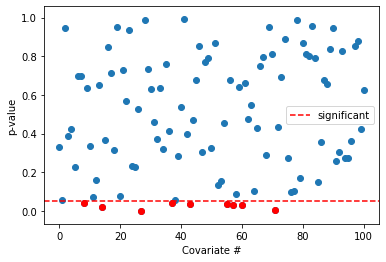

In [4]:
model = sm.OLS(y, sm.add_constant(X.T)).fit()
plt.scatter(range(n_metrics+1), model.pvalues )
sigs = model.pvalues[model.pvalues < 0.05]
sig_idxs = np.where(model.pvalues < 0.05)[0]
plt.scatter(sig_idxs, sigs,color="r" )
plt.axhline(0.05, color="r", ls="--", label="significant")
plt.legend()
plt.xlabel("Covariate #")
plt.ylabel("p-value")

# How likely are we see a false positive signal given we look at 20 metrics?
To do this we'll fit a regression on 20 metrics without an effect and test if we see 1 or more pvalues less than alpha = 0.05. We'll repeat this simulation 1000 times to estimate the probability it could occur

In [5]:

n_metrics = 20
N = 10000

res = []
for _ in range(1000):
    X = np.array([np.random.normal(0,1,size=N) for _ in range(n_metrics)])
    y = np.random.normal(0,1, size=N) 

    model = sm.OLS(y, sm.add_constant(X.T)).fit()
    pvals = model.pvalues[1:] # ignore the coefficient on the intercept
    res.append( (pvals < 0.05).sum() >= 1 )  
   

In [10]:
np.mean(res)

0.642

In [6]:
1 - 0.95**(20)

0.6415140775914581

### How about 2 metrics?

In [17]:
1 - 0.95**(2)

0.09750000000000003

In [18]:

n_metrics = 2
N = 10000

res = []
for _ in range(1000):
    X = np.array([np.random.normal(0,1,size=N) for _ in range(n_metrics)])
    y = np.random.normal(0,1, size=N) 

    model = sm.OLS(y, sm.add_constant(X.T)).fit()
    pvals = model.pvalues[1:] # ignore the coefficient on the intercept
    res.append( (pvals < 0.05).sum() >= 1 )  

np.mean(res)

0.107

# Can we fix this?

A common method to control the false positive rate is to use the Benjamini-Hochberg procedure. You may have heard of a bonferroni correction, which is more popular, however it tends to reduce the power to detect an effect far more than the Benjamini-Hochberg procedure.

The code below shows how the Benjamini-Hochberg procedure controls the false positive rate

In [33]:
n_metrics = 20
N = 10000

res = []
adj_res = []
for _ in range(1000):
    X = np.array([np.random.normal(0,1,size=N) for _ in range(n_metrics)])
    y = np.random.normal(0,1, size=N) 

    model = sm.OLS(y, sm.add_constant(X.T)).fit()
    
    pvals = model.pvalues[1:] # ignore the coefficient on the intercept
    _,adj_pvals,_,_ = sm.stats.multipletests(pvals, method="fdr_bh")
    
    res.append( (pvals < 0.05).sum() >= 1 )  
    adj_res.append( (adj_pvals < 0.05).sum() >= 1 )  

np.mean(res), np.mean(adj_res)

(0.634, 0.051)

Amazing, we reduced the false positive rate from 0.634 back down to 0.05. It's important to note that this comes at a price - the price you're paying is a reduced power to detect a true effect that may exist. But it does a fantastic job at controlling false positives

[TODO: add more details on benjamini hochberg correction later]

## What happens when we add in a few real effects? Can the Benjamini Hochberg procedure detect them? And how does it compare to the Bonferroni correction 